# Predicting non-functional water pumps in Tanzania

I decided take participation on current competition beckause I really care about future of the planet and water problem is global problem

"There is a water crisis today. But the crisis is not about having too little water to satisfy our needs. It is a crisis of managing water so badly that billions of people - and the environment - suffer badly."    World Water Vision Report

By 2020 about 30-40% of the world will have water scarcity, and according to the researchers, climate change can make this even worse.

By 2025, an estimated 1.8 billion people will live in areas plagued by water scarcity, with two-thirds of the world’s population living in water-stressed regions.


https://www.seametrics.com/blog/future-water/

About competition

https://www.drivendata.org/competitions/7/

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

# feature description

amount_tsh - Total static head (amount water available to waterpoint)

date_recorded - The date the row was entered

funder - Who funded the well

gps_height - Altitude of the well

installer - Organization that installed the well

longitude - GPS coordinate

latitude - GPS coordinate

wpt_name - Name of the waterpoint if there is one

num_private - No information about this column

basin - Geographic water basin

subvillage - Geographic location

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

lga - Geographic location

ward - Geographic location

population - Population around the well

public_meeting - True/False

recorded_by - Group entering this row of data

scheme_management - Who operates the waterpoint

scheme_name - Who operates the waterpoint

permit - If the waterpoint is permitted

construction_year - Year the waterpoint was constructed

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

management - How the waterpoint is managed

management_group - How the waterpoint is managed

payment - What the water costs

payment_type - What the water costs

water_quality - The quality of the water

quality_group - The quality of the water

quantity - The quantity of water

quantity_group - The quantity of water

source - The source of the water

source_type - The source of the water

source_class - The source of the water

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

# import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split, \
                RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# load data

In [61]:
train = pd.read_csv('data/raw/train.csv')
target = pd.read_csv('data/raw/target.csv')

# say hello to data

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [11]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


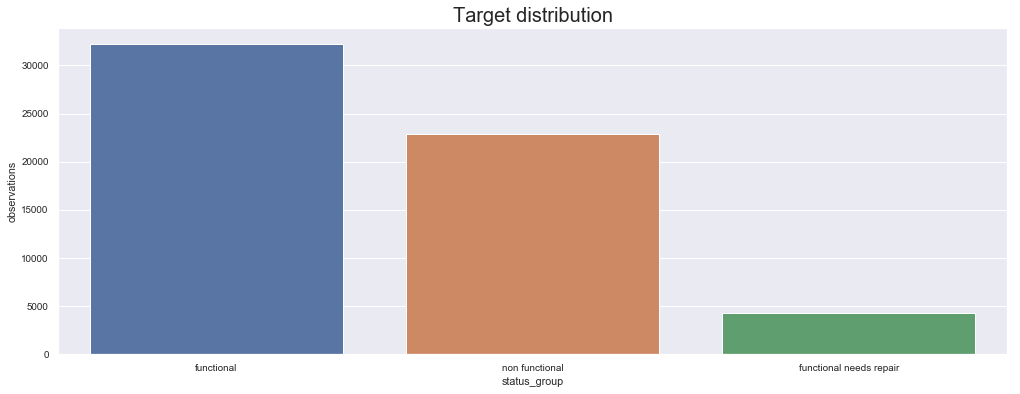

In [222]:
plt.figure(figsize=(17,6))
ax = sns.barplot(y="status_group", x='index', 
                 data=pd.DataFrame(target['status_group'].value_counts()).reset_index());
ax.set(ylabel='observations', xlabel = 'status_group')
ax.set_title('Target distribution', fontsize = 20)
plt.show()

# plot missing values

In [62]:
train[['amount_tsh', 'num_private', 'population' ,'construction_year']] = \
    train[['amount_tsh', 'num_private', 'population' ,'construction_year']].replace(0, np.NaN)

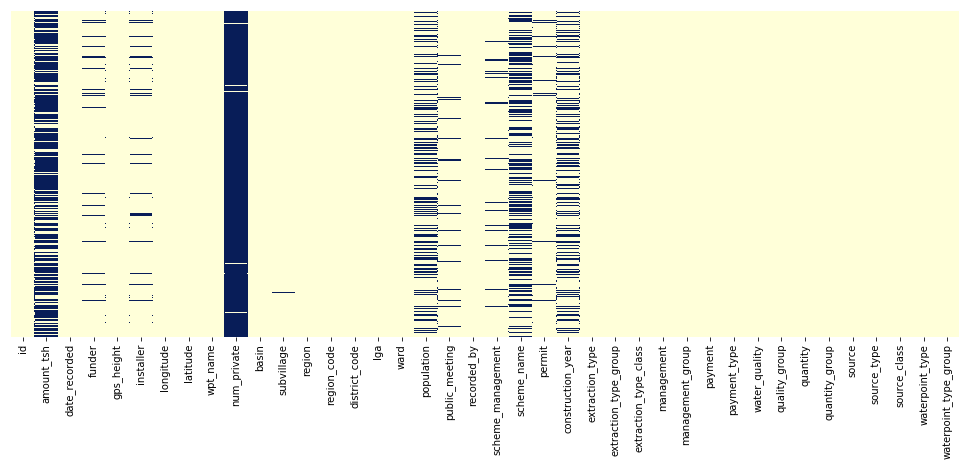

In [12]:
plt.figure(figsize=(17,6));
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap="YlGnBu")
plt.show()

# drop usless columns
scheme_name has a lot of missing data and it dont look like very informative

and num_private in mostly 0 (nan) and we dont know info about this colums

In [63]:
train.drop(['wpt_name', 'recorded_by', 'longitude', 'latitude','scheme_name', 'num_private'], 
           1, inplace=True)

region_code and district_code are integers, but categorical

devide data by info type

In [64]:
train[['region_code', 'district_code']]= train[['region_code', 'district_code']].astype('object')
train[['date_recorded']]= train[['date_recorded']].apply((pd.to_datetime))

categorical = train.select_dtypes(include = ['object']).columns.tolist()
numerical = train.select_dtypes(include = ['int', 'float']).columns.tolist()

merge target and features

In [65]:
df = pd.merge(train, target, how = 'inner', on = 'id')

# work with numerical features

In [11]:
numerical

['id', 'amount_tsh', 'gps_height', 'population', 'construction_year']

now 'id' no need to be keept

In [38]:
df.drop('id', 1, inplace=True)

population - Population around the well

check population distrib for geo features

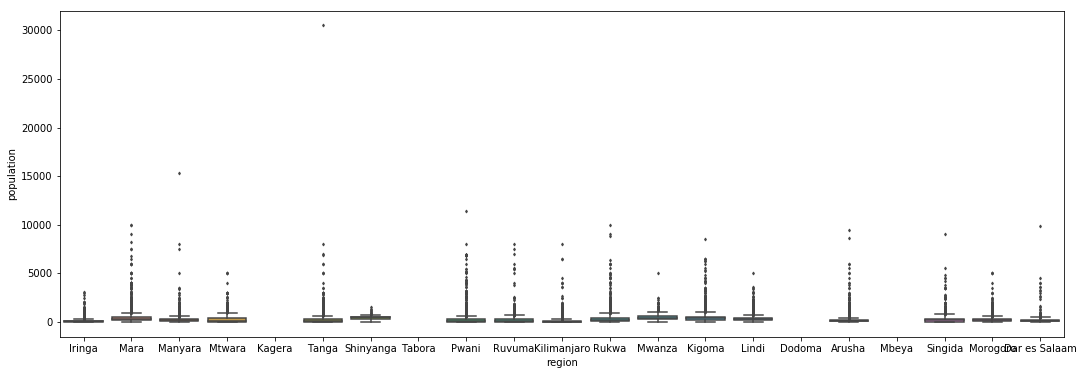

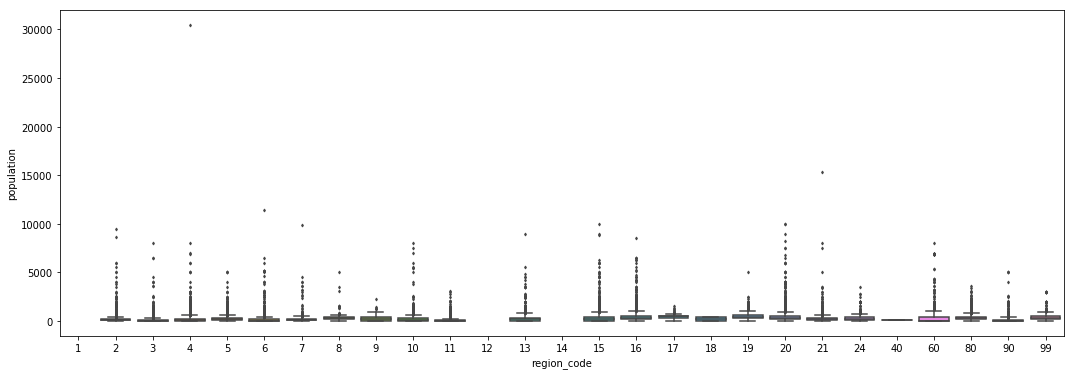

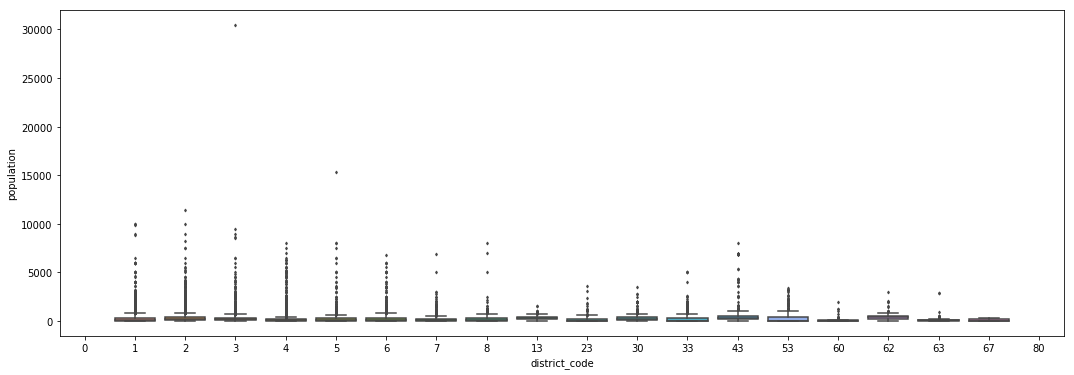

In [31]:
for col in ['region' , 'region_code', 'district_code']:
    plt.figure(figsize=(18, 6))
    sns.boxplot(x=col, y = 'population', data= df, fliersize = 2);

as I can see there a lot of outliers and try to fill missing population will be not precise, so I will just fill it with 0

In [39]:
df['missed_population'] = np.where(np.isnan(df['population']), 1, 0)
df['population'].fillna(0, inplace = True)

amount_tsh - Total static head (amount water available to waterpoint)

In [33]:
df.isnull().amount_tsh.sum()

41639

check amount_tsh distrib for water features

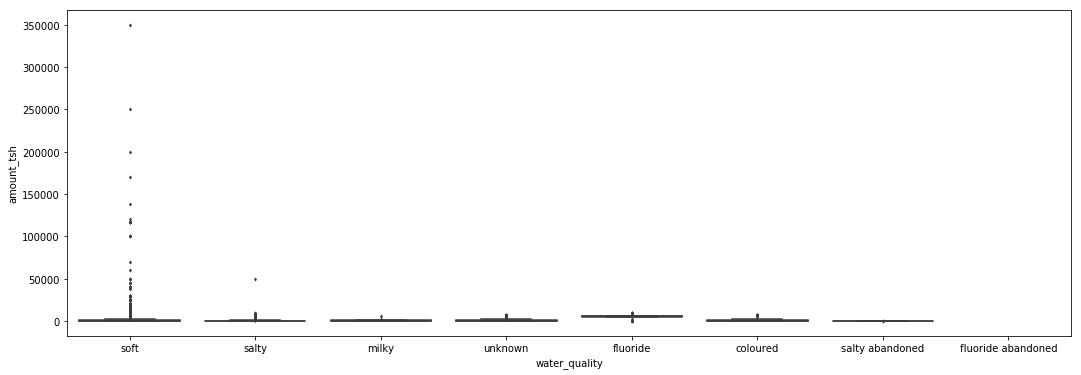

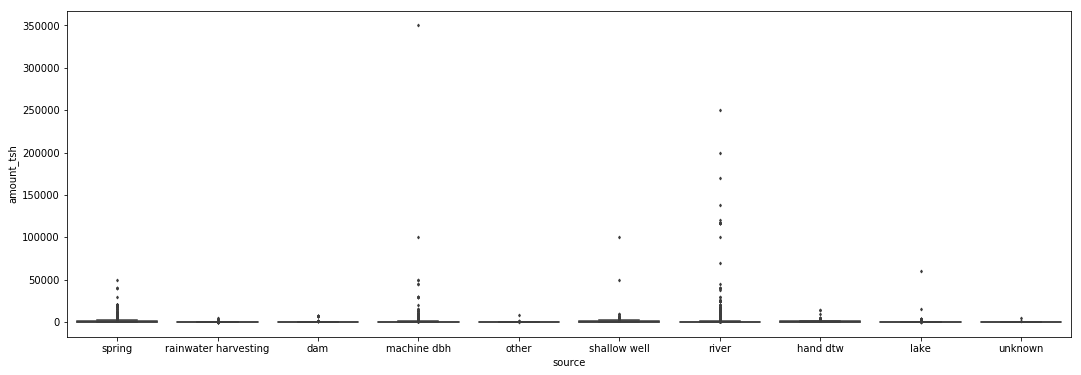

In [34]:
for col in ['water_quality' , 'source']:
    plt.figure(figsize=(18, 6))
    sns.boxplot(x=col, y = 'amount_tsh', data= df, fliersize = 2);


loocks like better to fill na with mode in water_quality groupe, except 'soft'

In [40]:
df['approximated_amount_tsh'] = np.where(np.isnan(df['amount_tsh']), 1, 0) 
replacements = df.groupby('water_quality').amount_tsh.agg(pd.Series.mode).to_dict()

# all vlaues amount_tsh in this category is Nan
replacements.pop('fluoride abandoned')

df.loc[df['water_quality'] != 'soft', 'amount_tsh'] = \
    df.loc[df['water_quality'] != 'soft', 'amount_tsh'].fillna(replacements)

df['amount_tsh'].fillna(0, inplace=True)

gps_height - Altitude of the well

info from Wiki 
The country is the site of Africa's highest and lowest points: Mount Kilimanjaro, at 5,895 metres (19,341 ft) above sea level, and the floor of Lake Tanganyika, at 352 metres (1,155 ft) below sea level, respectively. So it means there should not be negative values

In [41]:
df['wrong_gps_height'] = np.where(df['gps_height'] < 0, 1, 0) 

In [17]:
df['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

I think converting nevative values to positive would work pretty well

In [42]:
df['gps_height'] = abs(df['gps_height'])

# work with categorial features

count unique values of all column to estimate dataset shape after get_dummies

In [66]:
categories = 0
for col in categorical:
    categories += len(df[col].unique())
    print(col, len(df[col].unique()))
print('-------------------- \ntotal num:', categories)

funder 1898
installer 2146
basin 9
subvillage 19288
region 21
region_code 27
district_code 20
lga 125
ward 2092
public_meeting 3
scheme_management 13
permit 3
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6
-------------------- 
total num: 25771


looks very immense

Any feature values with fewer than 50 rows would be turned into a 'other'

In [43]:
df[categorical] = df[categorical].astype('str')
df[categorical] = df[categorical].applymap(lambda x: x.lower())
nan_list = ['not known','unknown','none','-','##','not kno','unknown installer', '0', 'dwe']
df = df.replace(nan_list, np.nan)

for feature in df[categorical]:
    # Determine which feature values to keep
    remove = df[feature].value_counts()[df[feature].value_counts() < 50].index.tolist()
    # Turn those into NANs (using a copy, to prevent warnings)
    feature_copy = df[feature].copy()
    #feature_copy[~feature_copy.isin(to_keep)] = np.nan
    feature_copy[feature_copy.isin(remove)] = np.nan
    #print(feature_copy.isnull().sum())
    df[feature] = feature_copy
# Fix all NANs
df[categorical] = df[categorical].fillna('other')

funder - Who funded the well

installer - Organization that installed the well

In [186]:
df[['installer', 'funder']].head(20)

,installer,funder
0,Roman,Roman
1,other,Grumeti
2,World vision,other
3,UNICEF,Unicef
4,Artisan,other
5,DWE,Mkinga Distric Coun
6,DWSP,Dwsp
7,DWE,Rwssp
8,other,Wateraid
9,Artisan,other


as we can see that funder and installer often have the same value or a little bit different, and DWE appears so often

and I cant find any info about this installer on the internet, so it could be smth like 'no info'

In [44]:
def plot_category_breakdown(df: pd.DataFrame = None, cat_col: str = None):
    '''
    plot count of every target group in every group for 'cat_col' column. ordered by nymber 
    of functional waterpomps in 'cat_col'
    
    Parameters:
        df: pd.DataFrame
            dataframe with info
        cat_col: str
            colum for grouping
    '''
    #order by the number of 'functioanl' waterpomps
    order = df.loc[df['status_group']=='functional', cat_col].value_counts().index
    with sns.axes_style('white'):
        g = sns.factorplot(cat_col, data=df[[cat_col, 'status_group']], aspect=3.0, kind='count',
                           hue='status_group', order = order)
        g.set_ylabels('Number of waterpomps')

basin - Geographic water basin

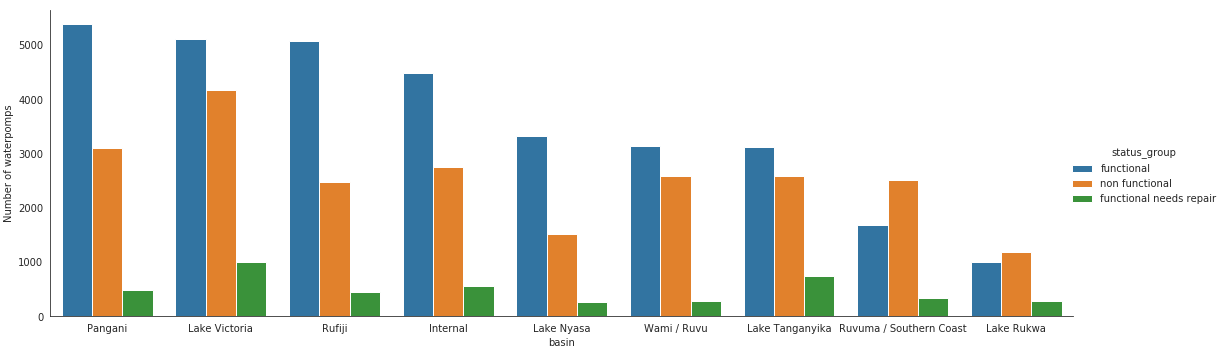

In [69]:
plot_category_breakdown(df, 'basin')

in this cases I would not amend feature 

region - Geographic location

region_code - Geographic location (coded)

district_code - Geographic location (coded)

region and region_code look like almost the same but have different unique values

In [70]:
print(len(df.region.unique()))
print(len(df.region_code.unique()))
print(len(df.district_code.unique()))

21
27
20


I checked that Tanzania has 31 region, so I will drop columns 'region' and 'district_code', beckause there is 
less values

In [45]:
df.drop(['region', 'district_code'], 1, inplace=True)
df['region_code'] = df['region_code'].astype(str)

extraction_type - The kind of extraction the waterpoint uses

extraction_type_group - The kind of extraction the waterpoint uses

extraction_type_class - The kind of extraction the waterpoint uses

extraction_type has very close values with extraction_type_group and extraction_type_class but extraction_type
has more values so I will 
remove extraction_type_group, extraction_type_class

In [46]:
df.drop(['extraction_type_group', 'extraction_type_class'], 1, inplace=True)

management - How the waterpoint is managed

management_group - How the waterpoint is managed

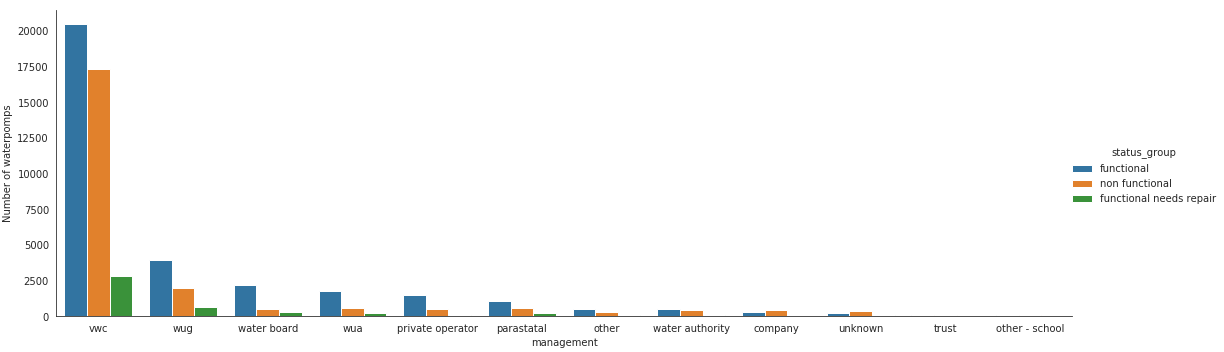

In [75]:
plot_category_breakdown(df, 'management')

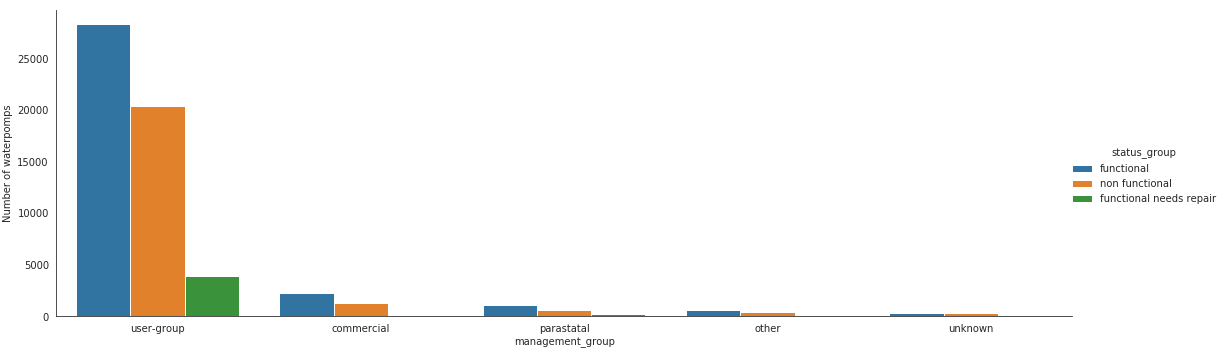

In [76]:
plot_category_breakdown(df, 'management_group')

majority of 'management' looks the same so I will remove this columns and leave 'management_group' and convert to

'user_group' - 1

'other' - 0

In [49]:
df['management_group'] = np.where(df['management_group'] == 'user-group', 1, 0)

dont need column 'management' any more

In [ ]:
df.drop('management', 1, inplace=True)

payment - What the water costs

payment_type - What the water costs

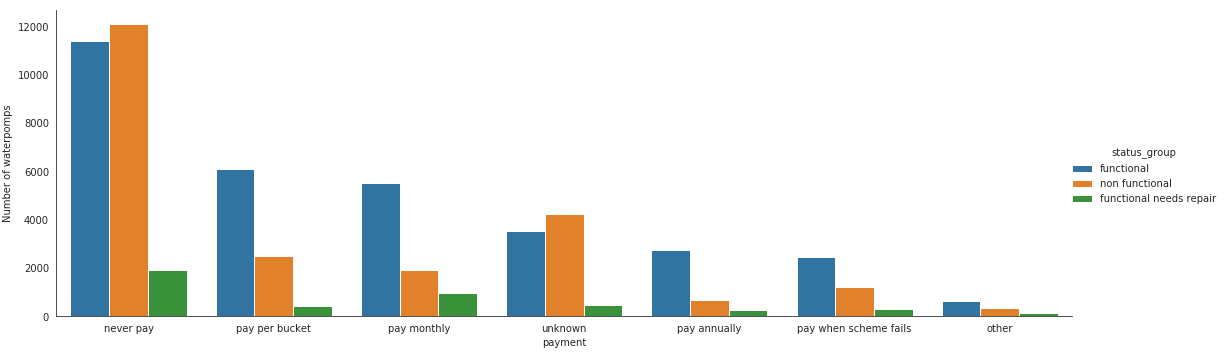

In [84]:
plot_category_breakdown(df,  'payment')

join pay to one group and others to another

In [51]:
unpayable_types = ['never pay', 'other']
df['payment'] = np.where(df['payment'].isin(unpayable_types), 0, 1)

'payment_type' shows the same info as 'payment'

In [52]:
df.drop('payment_type', 1, inplace=True)

water_quality - The quality of the water

quality_group - The quality of the water

quality_group looks very close to water_quality, so I will remove one

quantity_group and quantity have the same info, so I will remove second one and join 'other' with 'dry' beckause both groups are small

In [53]:
df.drop(['water_quality', 'quantity_group'], 1, inplace=True)
df.quantity.replace({'dry': 'other'}, inplace=True)

source - The source of the water

source_type - The source of the water

source_class - The source of the water

I will drop source_class and source_type becuase source is more detailed

In [54]:
df.drop(['source_class', 'source_type'], 1, inplace=True)

waterpoint_type - The kind of waterpoint

waterpoint_type_group - The kind of waterpoint

waterpoint_type_group and waterpoint_type looks the same but waterpoint_type more detailed

In [55]:
df.drop('waterpoint_type_group', 1, inplace=True)

I will join 2 small classes with close distribution

In [56]:
df['waterpoint_type'].replace({'cattle trough':'improved spring'}, inplace=True)

# work with date features

I will create 'lifetime' column from date_recorded and construction_year

In [57]:
print('number of nans:', df['construction_year'].isnull().sum())

number of nans: 20709


In [58]:
df['construction_year'] = df['construction_year'].fillna(0).astype(int)

coonst_y = list(df['construction_year'].unique())
coonst_y.sort()

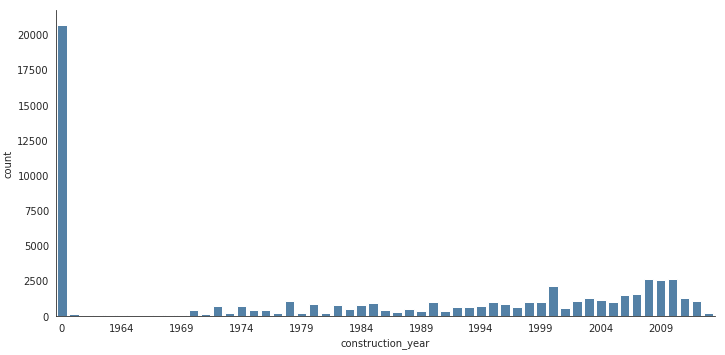

In [36]:
with sns.axes_style('white'):
    g = sns.factorplot("construction_year", data=df, aspect=2,
                       kind="count", color='steelblue', order = coonst_y)
    g.set_xticklabels(step=5)

add column that means that construction_year was filled with approximation

In [59]:
df['approximated_construction_year'] = np.where(df['construction_year'] == 0, 1, 0)

In [60]:
df['construction_year'] = df['construction_year'].replace(0, np.NaN)

fill missing values with mean values in group for the same 'funder', 'installer'

In [61]:
replacements = df.groupby(['funder', 'installer'])['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

fill missing values with mean values in group for the same 'installer'

In [62]:
replacements = df.groupby('installer')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

fill missing values with mean values in group for the same 'funder'

In [63]:
replacements = df.groupby('funder')['construction_year'].transform('mean').round(0)
df['construction_year'] = df['construction_year'].fillna(replacements)

fill missing values with mode

In [64]:
df.construction_year.fillna(df.construction_year.mode()[0], inplace=True)

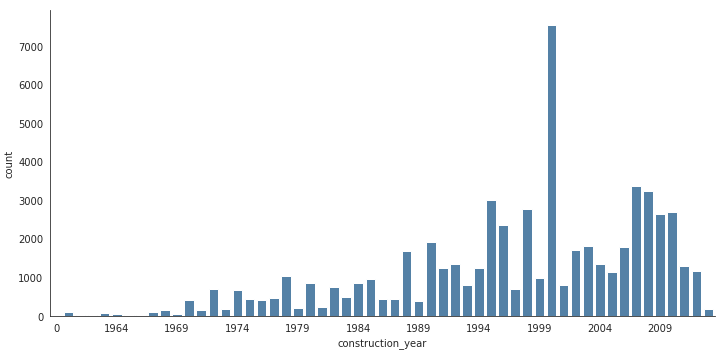

In [43]:
with sns.axes_style('white'):
    g = sns.factorplot("construction_year", data=df, aspect=2,
                       kind="count", color='steelblue', order = coonst_y)
    g.set_xticklabels(step=5)

add lifetime as 'date recorded' - 'construction_year'

In [65]:
df['lifetimes'] = df['date_recorded'].dt.year - df['construction_year']
df['lifetimes'] = np.where(df['lifetimes'] < 0, 0, df['lifetimes'] )

df.drop(['date_recorded', 'construction_year'], 1, inplace=True)

add column that represent number of watermomps in lga and ward, (for subwillage it doesnt work beckause 54000 rows would be without info)

In [66]:
wp_in_lga = df['lga'].value_counts().to_dict()
df['wp_in_lga'] = df['lga'].replace(wp_in_lga)

wp_in_ward = df['ward'].value_counts().to_dict()
df['wp_in_ward'] = df['ward'].replace(wp_in_ward)

df.drop(['subvillage', 'lga', 'ward'],1, inplace=True)

In [70]:
df.to_csv('data/processed/prepeared_features.csv', index=False)

# modelling

In [8]:
numerical = ['amount_tsh', 'gps_height', 'population', 'wp_in_lga', 'wp_in_ward', 'lifetimes']
binar = ['payment', 'missed_population', 'approximated_amount_tsh', 'wrong_gps_height', 
         'approximated_construction_year', 'management_group']
categorial = ['funder', 'installer', 'basin', 'region_code', 'public_meeting', 
              'scheme_management', 'permit', 'extraction_type', 'quality_group', 
              'quantity', 'source', 'waterpoint_type']
# without 'funder', 'installer' beckause they have too much values
categorial_short = ['basin', 'region_code', 'public_meeting', 'scheme_management',  
                    'permit', 'extraction_type', 'quality_group', 'quantity', 'source', 
                    'waterpoint_type']

In [9]:
target = df['status_group'].replace(['functional', 'non functional', 'functional needs repair'], 
                                    [2, 0, 1])

use get_dummies for converting categorical features

In [11]:
train_dum = pd.get_dummies(df[categorial_short], dummy_na=False, prefix = categorial_short)
train_dum.shape

(59400, 116)

In [12]:
df_preproc = pd.concat([train_dum, df[numerical + binar]], 1)

X_train, X_test, y_train, y_test = train_test_split(df_preproc, target, test_size=0.2, 
                                                    random_state=42, stratify = target)

calc baselines for different models

In [104]:
models = []

models.append(('LR', LogisticRegression(solver = 'lbfgs', multi_class='auto')))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
models.append(('XGBT', XGBClassifier(silent=True, n_jobs = -1)))
models.append(('CatBST', CatBoostClassifier(silent=True)))
models.append(('LGBM', LGBMClassifier(silent=True)))

accuracy_results = []
time_to_fit = []
names = []

for name, model in models:
    kfold = KFold(n_splits=7, random_state=42)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy')
    accuracy_results.append(cv_results['test_score'])
    time_to_fit.append(cv_results['fit_time'])
    names.append(name)
    msg = '%s: %f (%f), takes: %f' % (name, cv_results['test_score'].mean(), 
                           cv_results['test_score'].std(), 
                           cv_results['fit_time'].mean())
    print(msg)

LR: 0.565299 (0.012515), takes: 1.842960
RF: 0.777883 (0.005210), takes: 0.669045
ET: 0.771864 (0.004533), takes: 0.663674
XGBT: 0.744844 (0.003535), takes: 6.298543
CatBST: 0.775063 (0.004130), takes: 129.653371
LGBM: 0.777062 (0.005101), takes: 3.168724


# Compare baselines

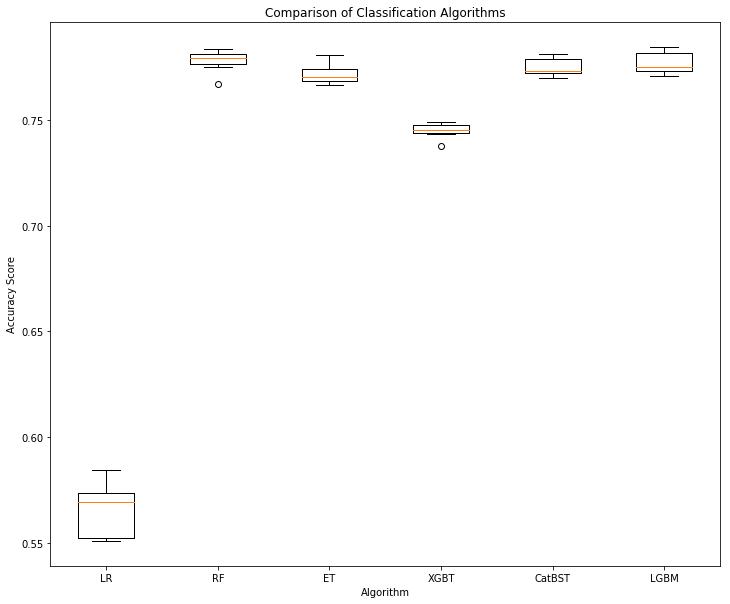

In [105]:
fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy Score')
plt.boxplot(accuracy_results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

# preprocess numeric features 

Robost shows better resulte than: Normalization, MinMaxScaler, ang logarithm

In [13]:
df_preproc_numeric = df_preproc.copy()

scaler = RobustScaler()
nums_scaled = scaler.fit_transform(df_preproc_numeric[numerical])
nums_scaled = pd.DataFrame(nums_scaled, columns=numerical)
df_preproc_numeric[numerical] = nums_scaled

I took best clissifier to check how accuracy grow

In [107]:
rfc = LGBMClassifier(silent=True, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(df_preproc_numeric, target, test_size=0.2, 
                                                    random_state=42, stratify = target)

rfc.fit(X_train, y_train)
accuracy_score(y_test, rfc.predict(X_test), normalize=True)

0.7827441077441077

# preprocess categorical features


define categorical features for LightGBM

In [15]:
lgbm_c = LGBMClassifier(silent=True, categorical_feature = list(range(len(categorial) - 1)))
# label cat features
df_cat_labeled = df.copy() 
le = LabelEncoder()
df_cat_labeled[categorial] = df_cat_labeled[categorial].apply(lambda col: 
                                                              le.fit_transform(col.astype(str).fillna('nan')), 
                                                              axis = 0)

In [108]:
df_cat_labeled_full = pd.concat([df_cat_labeled[categorial], 
                                 df_cat_labeled[numerical], 
                                 df_cat_labeled[binar]], 
                                axis = 1)
X_train, X_test, y_train, y_test = train_test_split(df_cat_labeled_full, target, test_size=0.2, 
                                                    random_state=42, stratify = target)
lgbm_c.fit(X_train, y_train)
accuracy_score(y_test, lgbm_c.predict(X_test), normalize=True)

0.7887205387205387

CatBoost

In [109]:
catboost_c = CatBoostClassifier(silent=True, cat_features = categorial)
X_train, X_test, y_train, y_test = train_test_split(df.fillna('none').drop('status_group', 1),
                                                    target, test_size=0.2, random_state=42, 
                                                    stratify = target)
catboost_c.fit(X_train, y_train)

In [111]:
accuracy_score(y_test, catboost_c.predict(X_test), normalize=True)

0.79006734006734

Target_encoding

In [121]:
y_works = [1.0 if x == 2 else 0.0 for x in target]
y_broken = [1.0 if x == 0 else 0.0 for x in target]
y_repair = [1.0 if x == 1 else 0.0 for x in target]
y_vectors = [y_works, y_broken, y_repair]
X_TE_all = []

df_cats_target = df.drop('status_group', 1).copy()

from category_encoders.target_encoder import TargetEncoder

# We want to create encoding based on the training features and 
# labels, but apply this encoding to any vector (such as X_test)
for i in [1,2,3]:
     # Make an encoder
    TE = TargetEncoder()
     
     # Fit it to the training data
    TE.fit(X=df_cats_target[categorial], y=y_vectors[i-1])
     # Transform the cat columns in X
    X_TE = TE.transform(df_cats_target[categorial])
     
     # Give them custom names, so that the columns encoded against
     # each target vector have a different name
    X_TE = X_TE.rename(columns=(lambda x: x + '_TE' + str(i)))
    X_TE_all.append(X_TE)
new_cats = pd.concat(X_TE_all, sort=False, axis=1)
 
train_TE = df_cats_target.drop(columns=categorial)
train_TE = pd.concat([train_TE, new_cats], sort=False, axis=1)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(train_TE, target, test_size=0.2, 
                                                    random_state=42, stratify = target)

In [123]:
rfc.fit(X_train, y_train)
accuracy_score(y_test, rfc.predict(X_test), normalize=True)

0.7855218855218855

# best estimator

CatBoost take too much time to fit, so I will train LightGBM on Random grid search

In [16]:
df_super_features = df_preproc_numeric.copy() 
df_super_features[categorial] = df_cat_labeled[categorial]

In [17]:
df_super_features = pd.concat([df_super_features[categorial], 
                               df_super_features[numerical+binar]], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(df_super_features, target, test_size=0.2, 
                                                    random_state=42, stratify = target)
lgbm_c.fit(X_train, y_train)
accuracy_score(y_test, lgbm_c.predict(X_test), normalize=True)

0.7906565656565656

In [130]:
param_dist = {"max_depth": [10, 25, 50, 75],
              "learning_rate" : [0.01, 0.05, 0.1],
              "num_leaves": [50, 100, 300, 900, 1200],
              "n_estimators": [50, 100, 200],
              'feature_fraction' : [0.5, 0.8, 1],
              'bagging_fraction' : [0.8, 0.9, 1]
             }
lg_gs = RandomizedSearchCV(lgbm_c, 
                           n_jobs=-1, 
                           n_iter=100,
                           param_distributions=param_dist, 
                           cv = 7, 
                           scoring="accuracy", 
                           verbose=5)

lg_gs.fit(X_train, y_train)
lg_gs.best_estimator_

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed: 22.8min finished


LGBMClassifier(bagging_fraction=1, boosting_type='gbdt',
               categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.05, max_depth=25,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=300, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [131]:
accuracy_score(y_test, lg_gs.predict(X_test), normalize=True)

0.8097643097643098

classification report

In [42]:
y_pred = lg_gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4565
           1       0.61      0.31      0.41       863
           2       0.80      0.90      0.85      6452

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.69     11880
weighted avg       0.80      0.81      0.80     11880



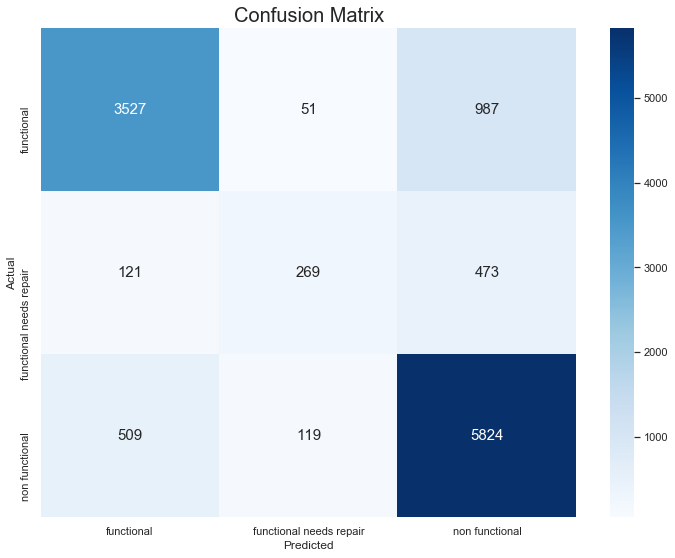

In [228]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
classes = ['functional', 'functional needs repair', 'non functional']
df_cm = pd.DataFrame(confmat, columns=classes, index = classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12,9))

ax = plt.axes()
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d");
sns.set(font_scale=0.9)
ax.set_title('Confusion Matrix', fontsize = 20)
plt.show()

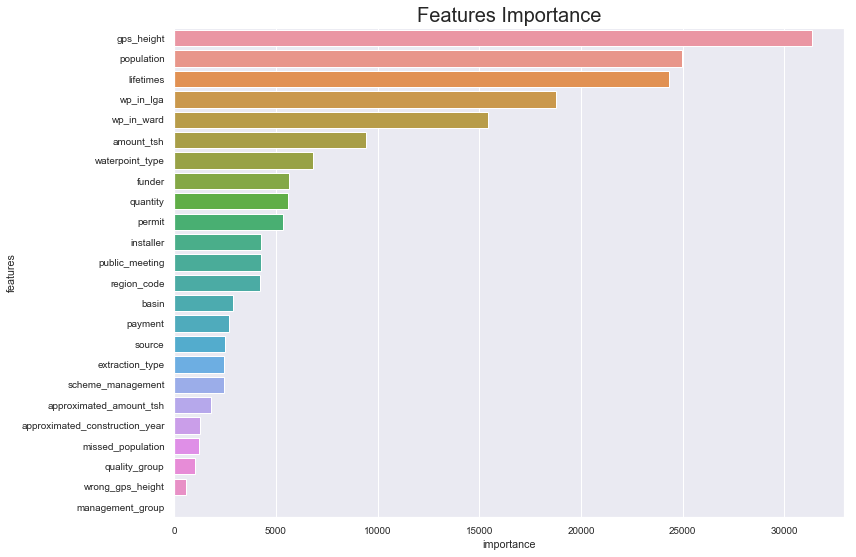

In [177]:
df_fe = pd.DataFrame(lg_gs.best_estimator_.feature_importances_, index = X_train.columns,
                     columns=['importance']).sort_values('importance',ascending=False)
plt.figure(figsize = (12,9))


ax = sns.barplot(x="importance", y='index', data=df_fe.reset_index());
ax.set(ylabel='features')
ax.set_title('Features Importance', fontsize = 20)
plt.show()

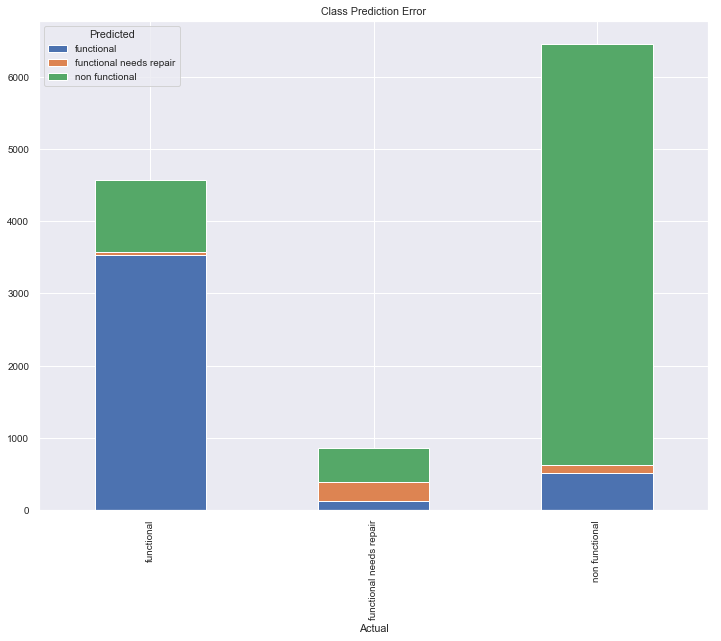

In [59]:
df_cm.plot(kind='bar', stacked=True, figsize = (12,9), title = 'Class Prediction Error');

# save model

In [202]:
lg_gs.best_estimator_.booster_.save_model('models/LightGmb.txt')

to load model

In [2]:
from lightgbm import Booster

In [33]:
lg_gs = Booster(model_file='models/LightGmb.txt')